# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Business Understanding

In [1]:
import datetime
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
% matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Understanding: Initial Exploratory analysis and data cleaning

## Portfolio dataframe

We notice that this relates to the different offers: offer ids and metadata about each offer (duration, type, etc.).

In [2]:
portfolio.shape

(10, 6)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


We notice from above that there are no missing values

In [5]:
#check for duplicate rows
portfolio[portfolio.duplicated(['id'], keep=False)]

,channels,difficulty,duration,id,offer_type,reward


In [6]:
#check for unique type of offers
portfolio['id'].nunique()

10

In [7]:
# count of the number of offers by offer type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [9]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [10]:
# Create a copy of portfolio change the duration from day to hour
clean_portfolio = portfolio.copy()
clean_portfolio['duration'] = clean_portfolio['duration'] * 24

In [11]:
clean_portfolio.head(2)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


In [12]:
# apply one hot encoding to channels culumn
channels=clean_portfolio['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep=',')

In [13]:
channels.head(2)

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1


In [14]:
#apply one hot encoding to offer_type column
offer_type = pd.get_dummies(clean_portfolio['offer_type'])

In [15]:
offer_type.head(2)

,bogo,discount,informational
0,1,0,0
1,1,0,0


In [16]:
# drop the columns channels and offer_type 
clean_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

In [17]:
clean_portfolio.head(2)

,difficulty,duration,id,reward
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10


In [18]:
# re-combine the dataframe clean_portfolio and offer_type to create the cleaned dataframe
clean_portfolio = pd.concat([clean_portfolio, channels, offer_type], axis=1, sort=False)

In [19]:
clean_portfolio

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


In [20]:
clean_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
difficulty       10 non-null int64
duration         10 non-null int64
id               10 non-null object
reward           10 non-null int64
email            10 non-null int64
mobile           10 non-null int64
social           10 non-null int64
web              10 non-null int64
bogo             10 non-null uint8
discount         10 non-null uint8
informational    10 non-null uint8
dtypes: int64(7), object(1), uint8(3)
memory usage: 750.0+ bytes


## Profile dataframe cleaning and pre-processing

We notice that this table relates to the customer: demographic data for every customer 

In [21]:
profile.shape

(17000, 5)

In [22]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [23]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


We notice above that there are missing values

In [24]:
# view total count of missing values 
print(profile.isnull().sum().sum())

4350


In [25]:
 missing_values = profile[profile['gender'].isnull()] 

Investigation of missing values

In [26]:
missing_values.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [27]:
# View records of profile dataframe for age 118
profile_118 = profile[profile['age'] == 118]

Let's have a look at a graph using age

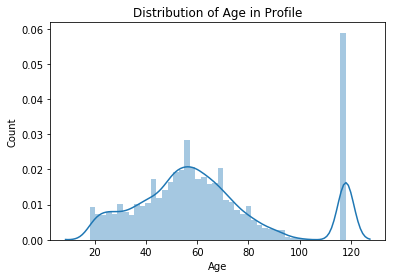

In [28]:
# sns.distplot(profile['age'],hist=True)
sns.distplot(profile['age'],hist=True)
plt.title("Distribution of Age in Profile")
plt.xlabel("Age")
plt.ylabel("Count");

In [29]:
# Remove customers with age 118
profile_118 = profile[profile['age'] == 118]
profile.drop(index=profile_118.index, inplace=True) 

After removing the records realing to the 118 year old, the graph should look better

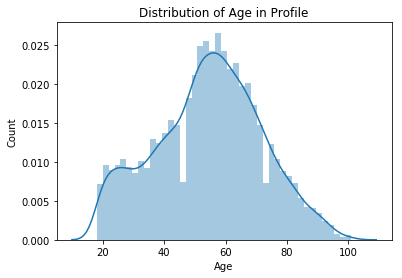

In [30]:
# sns.distplot(profile['age'],hist=True)
sns.distplot(profile['age'],hist=True)
plt.title("Distribution of Age in Profile")
plt.xlabel("Age")
plt.ylabel("Count");

In [31]:
# view total count of missing values after 118 year old is removed
print(profile.isnull().sum().sum())

0


In [32]:
# make copy called clean_profile change name of column id to customer_id in profile dataframe
clean_profile = profile.copy()
clean_profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [33]:
# feature extraction the number of days since the user is a member of starbucks
clean_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.date
clean_profile['memberdays'] = clean_profile['memberdays'].dt.days

In [34]:
clean_profile.head()

,age,became_member_on,gender,customer_id,income,memberdays
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1382
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1449
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1097
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1173
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1263


In [35]:
# drop the became_member_on column
clean_profile.drop(['became_member_on'], axis=1, inplace=True)

In [36]:
clean_profile.head()

,age,gender,customer_id,income,memberdays
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1382
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1449
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1097
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,1173
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1263


In [98]:
clean_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age            14825 non-null int64
gender         14825 non-null object
customer_id    14825 non-null object
income         14825 non-null float64
memberdays     14825 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ MB


## Transcript dataframe cleaning

In [38]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [39]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [40]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [41]:
# select one user and explore the transcript records
transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [42]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [43]:
offer = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [44]:
offer.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [45]:
offer.shape

(167581, 5)

In [46]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [47]:
# check how many times the offer has sent
offer[offer['event']=='offer received']['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [48]:
# check the same user transcript records
offer[offer['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value,offer_id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4


In [95]:
offer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 5 columns):
event       167581 non-null object
person      167581 non-null object
time        167581 non-null int64
value       167581 non-null object
offer_id    167581 non-null object
dtypes: int64(1), object(4)
memory usage: 7.7+ MB


# Exploratory Data Analysis(EDA):


In [49]:
clean_profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

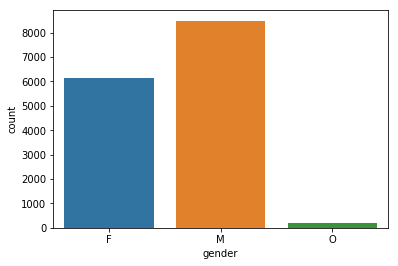

In [50]:
sns.countplot(x='gender',data=clean_profile);

In [51]:
clean_profile[clean_profile['income'].notnull()][['age']].describe() #'income', 

,age
count,14825.000000
mean,54.393524
std,17.383705
min,18.000000
25%,42.000000
50%,55.000000
75%,66.000000
max,101.000000


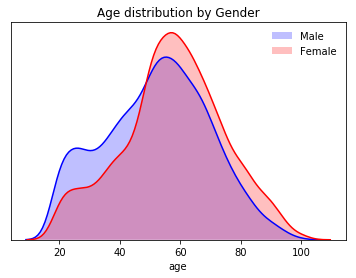

In [52]:
sns.distplot(profile[profile['gender']=='M']['age'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['age'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Age distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);

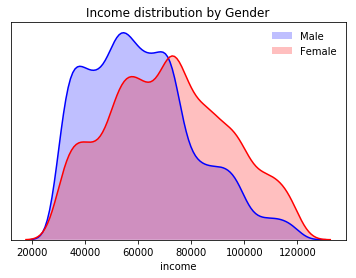

In [53]:
sns.distplot(profile[profile['gender']=='M']['income'],hist=False,color="b", kde_kws={"shade": True});
sns.distplot(profile[profile['gender']=='F']['income'],hist=False,color="r", kde_kws={"shade": True});
plt.title('Income distribution by Gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female'],frameon=False);

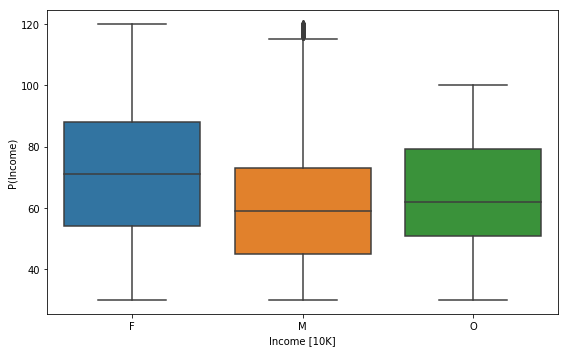

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot('gender', profile['income']*1E-3, data = profile)
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.tight_layout()

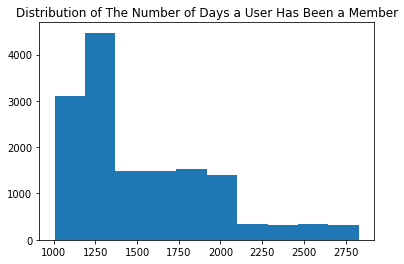

In [55]:
plt.hist(clean_profile['memberdays']);
plt.title('Distribution of The Number of Days a User Has Been a Member');

# Data Modeling

## Create user-item matrix

The dataset needs to be in user-item matrix format to be used y the recommendation engine. Following functions will help further transform the datasets

In [56]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer completed by the user (NaN means no offer given)
        - The matrix is written to a pickle file
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we  focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                    #Reddit user_item_matrix.drop(portfolio[portfolio['offer_type']=='informational']), axis=1, inplace=True)
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into a pickle file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [57]:
#full_df = create_user_item_matrix(offer, 'user_item_matrix.p') #Takes 2 hours to run

In [58]:
#full_df.head(2)

In [59]:
#Set the traning test split to 70:30
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [60]:
train_offer = offer[:train_size]

In [61]:
train_offer.head(2)

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [62]:
test_offer = offer[train_size:]

In [63]:
test_offer.head(2)

,event,person,time,value,offer_id
209139,offer received,ee17ec3543154db188a6afa0d74b7e9f,504,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
209140,offer received,b148b540df8c4aa5a8a0b79be4fdecbe,504,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},5a8bc65990b245e5a138643cd4eb9837


In [64]:
#train_df = create_user_item_matrix(train_offer, 'train_df.p') #runs about 10 mins

In [65]:
#train_df.head

In [66]:
# Run this cell if you want to avoid the long process of matrix creation
full_df = pd.read_pickle('user_item_matrix.p')

In [67]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16994 entries, 0009655768c64bdeb2e877511632db8f to ffff82501cea40309d5fdd7edcca4a07
Data columns (total 8 columns):
0b1e1539f2cc45b7b9fa7c272da2e1d7    6374 non-null float64
2298d6c36e964ae4a3e7e9706d1fb8c2    6325 non-null float64
2906b810c7d4411798c6938adc9daaa5    6285 non-null float64
4d5c57ea9a6940dd891ad53e9dbe8da0    6330 non-null float64
9b98b8c7a33c4b65b9aebfe6a799e6d9    6355 non-null float64
ae264e3637204a6fb9bb56bc8210ddfd    6374 non-null float64
f19421c1d4aa40978ebb69ca19b0e20d    6262 non-null float64
fafdcd668e3743c1bb461111dcafc2a4    6332 non-null float64
dtypes: float64(8)
memory usage: 1.2+ MB


In [68]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [69]:
# Run this cell if you want to omit the long process of matrix creation
train_df = pd.read_pickle('train_df.p')

In [70]:
train_df.info(3)

<class 'pandas.core.frame.DataFrame'>
Index: 16955 entries, 0009655768c64bdeb2e877511632db8f to ffff82501cea40309d5fdd7edcca4a07
Data columns (total 8 columns):
0b1e1539f2cc45b7b9fa7c272da2e1d7    5145 non-null float64
2298d6c36e964ae4a3e7e9706d1fb8c2    5066 non-null float64
2906b810c7d4411798c6938adc9daaa5    5098 non-null float64
4d5c57ea9a6940dd891ad53e9dbe8da0    5115 non-null float64
9b98b8c7a33c4b65b9aebfe6a799e6d9    5105 non-null float64
ae264e3637204a6fb9bb56bc8210ddfd    5142 non-null float64
f19421c1d4aa40978ebb69ca19b0e20d    5065 non-null float64
fafdcd668e3743c1bb461111dcafc2a4    5078 non-null float64
dtypes: float64(8)
memory usage: 1.2+ MB


In [71]:
# Run this cell if you want to omit the long process of matrix creation
test_df = pd.read_pickle('test_df.p')

In [72]:
test_df.head(2)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [73]:
#Create test df. This takes around 20 mins, please read the pickle file if too long
#test_df = create_user_item_matrix(test_offer, 'test_df.p') 

## Applying the Funk SVD model

In [74]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up required values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [75]:
#create numpy array of training matrix
train_data_np = np.array(train_df)

In [76]:
train_data_np

array([[ nan,  nan,  nan, ...,  nan,   0.,   0.],
       [ nan,  nan,  nan, ...,  nan,   0.,  nan],
       [  0.,   1.,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,   0.],
       [ nan,  nan,  nan, ...,  nan,   1.,  nan],
       [  1.,  nan,   2., ...,  nan,  nan,   1.]])

### Fitting of FunkSVD with 4 different amounts of latent_features

In [77]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.318160
2 		 0.268062
3 		 0.267718
4 		 0.267363
5 		 0.267005
6 		 0.266643
7 		 0.266277
8 		 0.265907
9 		 0.265531
10 		 0.265150
11 		 0.264764
12 		 0.264372
13 		 0.263973
14 		 0.263567
15 		 0.263154
16 		 0.262733
17 		 0.262304
18 		 0.261865
19 		 0.261417
20 		 0.260958
21 		 0.260488
22 		 0.260006
23 		 0.259510
24 		 0.259001
25 		 0.258477
26 		 0.257937
27 		 0.257380
28 		 0.256805
29 		 0.256210
30 		 0.255594
31 		 0.254956
32 		 0.254294
33 		 0.253607
34 		 0.252892
35 		 0.252149
36 		 0.251374
37 		 0.250567
38 		 0.249725
39 		 0.248845
40 		 0.247927
41 		 0.246966
42 		 0.245961
43 		 0.244910
44 		 0.243809
45 		 0.242657
46 		 0.241449
47 		 0.240185
48 		 0.238860
49 		 0.237472
50 		 0.236018
51 		 0.234496
52 		 0.232903
53 		 0.231236
54 		 0.229493
55 		 0.227672
56 		 0.225770
57 		 0.223786
58 		 0.221719
59 		 0.219567
60 		 0.217329
61 		 0.215005
62 		 0.212594
63 		 0.210098
64 		 0

In [78]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.280885
2 		 0.268847
3 		 0.268004
4 		 0.267157
5 		 0.266309
6 		 0.265460
7 		 0.264610
8 		 0.263759
9 		 0.262907
10 		 0.262054
11 		 0.261199
12 		 0.260343
13 		 0.259485
14 		 0.258627
15 		 0.257766
16 		 0.256904
17 		 0.256040
18 		 0.255174
19 		 0.254305
20 		 0.253435
21 		 0.252562
22 		 0.251686
23 		 0.250808
24 		 0.249926
25 		 0.249042
26 		 0.248153
27 		 0.247262
28 		 0.246365
29 		 0.245465
30 		 0.244560
31 		 0.243650
32 		 0.242735
33 		 0.241814
34 		 0.240887
35 		 0.239954
36 		 0.239013
37 		 0.238066
38 		 0.237110
39 		 0.236147
40 		 0.235175
41 		 0.234193
42 		 0.233202
43 		 0.232200
44 		 0.231188
45 		 0.230164
46 		 0.229128
47 		 0.228079
48 		 0.227018
49 		 0.225942
50 		 0.224852
51 		 0.223746
52 		 0.222625
53 		 0.221488
54 		 0.220333
55 		 0.219161
56 		 0.217971
57 		 0.216761
58 		 0.215533
59 		 0.214284
60 		 0.213015
61 		 0.211724
62 		 0.210412
63 		 0.209078
64 		 0

In [79]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.296297
2 		 0.266261
3 		 0.265802
4 		 0.265328
5 		 0.264852
6 		 0.264373
7 		 0.263892
8 		 0.263407
9 		 0.262919
10 		 0.262427
11 		 0.261932
12 		 0.261432
13 		 0.260928
14 		 0.260419
15 		 0.259905
16 		 0.259385
17 		 0.258859
18 		 0.258327
19 		 0.257788
20 		 0.257242
21 		 0.256687
22 		 0.256124
23 		 0.255552
24 		 0.254969
25 		 0.254377
26 		 0.253772
27 		 0.253156
28 		 0.252527
29 		 0.251884
30 		 0.251226
31 		 0.250552
32 		 0.249862
33 		 0.249153
34 		 0.248426
35 		 0.247678
36 		 0.246908
37 		 0.246116
38 		 0.245299
39 		 0.244456
40 		 0.243587
41 		 0.242688
42 		 0.241759
43 		 0.240799
44 		 0.239805
45 		 0.238776
46 		 0.237710
47 		 0.236606
48 		 0.235462
49 		 0.234276
50 		 0.233047
51 		 0.231773
52 		 0.230453
53 		 0.229086
54 		 0.227669
55 		 0.226202
56 		 0.224684
57 		 0.223114
58 		 0.221490
59 		 0.219813
60 		 0.218083
61 		 0.216297
62 		 0.214458
63 		 0.212565
64 		 0

In [80]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_20, offer_mat_20 = FunkSVD(train_data_np, latent_features=20, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.344795
2 		 0.269073
3 		 0.268788
4 		 0.268481
5 		 0.268167
6 		 0.267848
7 		 0.267523
8 		 0.267192
9 		 0.266854
10 		 0.266508
11 		 0.266154
12 		 0.265791
13 		 0.265419
14 		 0.265037
15 		 0.264645
16 		 0.264240
17 		 0.263824
18 		 0.263394
19 		 0.262950
20 		 0.262491
21 		 0.262016
22 		 0.261522
23 		 0.261011
24 		 0.260479
25 		 0.259925
26 		 0.259348
27 		 0.258747
28 		 0.258120
29 		 0.257464
30 		 0.256778
31 		 0.256060
32 		 0.255309
33 		 0.254521
34 		 0.253694
35 		 0.252827
36 		 0.251916
37 		 0.250960
38 		 0.249955
39 		 0.248900
40 		 0.247790
41 		 0.246624
42 		 0.245399
43 		 0.244112
44 		 0.242761
45 		 0.241341
46 		 0.239853
47 		 0.238291
48 		 0.236655
49 		 0.234942
50 		 0.233149
51 		 0.231276
52 		 0.229321
53 		 0.227282
54 		 0.225158
55 		 0.222950
56 		 0.220656
57 		 0.218278
58 		 0.215815
59 		 0.213270
60 		 0.210642
61 		 0.207936
62 		 0.205152
63 		 0.202295
64 		 0

In [81]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Offer Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

# Evaluation/Validation of the model

In [82]:
def validation(test_df, user_mat, offer_mat):
    '''
    Measure the squared errors for the prediction
    INPUT:
    test_df - applicable dataset to be evaluated
    user_mat - user-matrix for applicable latent features
    offer_mat - offer-matrix for applicable latent features
    
    OUTPUT:
    evaluation - the MSE for applicable latent features
    '''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [83]:
## Evaluation for latent features of 20
validation(test_df, user_mat_20, offer_mat_20)

0.336090651683


In [84]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.331247516925


In [85]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.3356152824


In [86]:
## Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.324403639939


## Recommendation of an offer to users

In [87]:
def recommend_offer(user_id, user_mat, offer_mat):
    ''' 
    INPUT:
    user_id - one single user-id
    user_mat - user-matrix
    offer_mat - offer-matrix
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id as predicted by FunkSVD
    '''    
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user is not in our database, we are offering the top sale offer recommendation.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [96]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.79
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.52
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.43
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.1
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  -0.18
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.21
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.52
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.63


In [89]:
def best_sale_offer(user_item_matrix):
    
    '''
    Get list of offers that sell the best
    INPUT:
    user_item_matrix - matrix with offer as columns and user as rows
        
    OUTPUT:
    offer_value - dataframe of offers
    '''
    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    return offer_value

Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


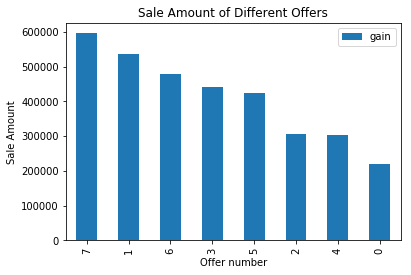

In [97]:
# we recommend top best sale offer to a brand new user
recommend_offer('new_user', user_mat, offer_mat)